**Redes neurais recorrentes**

Para clarificar os conceitos de *loop* e *estado*, relevantes no aprendizado do conceito de uma **rede neural recorrente**, vamos implementar a *forward pass* de uma RNN simples em Numpy. Esta RNN recebe como entrada uma sequência de vetores, que será codificada como um tensor 2D de tamanho `(timesteps, input_features)`. Ela percorre os *timesteps* e, em cada *timestep, considera seu estado atual em `t` e a entrada em `t` (de formato `(input_features,)`) e os combina para obter a saída em `t`. Em seguida, define-se o estado para o próximo passo como sendo esta saída anterior. Para o primeiro passo temporal, a saída anterior não está definida; portanto, não há estado atual. Assim, inicializaremos o estado como um vetor todo de zeros chamado o estado inicial da rede.

In [1]:
### RNN em pseudo-código

# state_t = 0                       #The state at t
# for input_t in input_sequence:    #Iterates over sequence elements
#   output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
#   state_t = output_t              #The previous output becomes the state for the next iteration.

Para tornar esses conceitos absolutamente inequívocos, vamos escrever uma implementação ingênua em Numpy para a *forward pass* de uma RNN simples.

In [2]:
# Set seed for reproducibility
from keras.utils import set_random_seed
from keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

# Import custom plots
from plot_utils import plot_1model_train_val_charts, plot_train_val_charts, plot_train_val_loss

In [3]:
### Numpy implementation of a simple RNN

timesteps = 100           #Number of timesteps in the input sequence
input_features = 32       #Dimensionality of the input feature space
output_features = 64      #Dimensionality of the output feature space

#Input data: random noise for the sake of the example
inputs = np.random.random((timesteps, input_features))

#Initial state: an all-zero vector
state_t = np.zeros((output_features,))

#Creates random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
  #Combines the input with the current state (the previous output) to obtain the current output
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  #Stores this output in a list
  successive_outputs.append(output_t)
  #Updates the state of the network for the next timestep
  state_t = output_t

#The final output is a 2D tensor of shape (timesteps, output_features).
final_output_sequence = np.concatenate(successive_outputs, axis=0)

 Em suma, uma RNN é um loop *for* que reutiliza quantidades calculadas durante a iteração anterior do loop, nada mais. Claro, há muitas RNNs diferentes que se encaixam nessa definição - este exemplo é uma das formulações mais simples de RNN. RNNs são caracterizadas por sua *step funcion*, como a seguinte função neste caso:

 `output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)`

NOTA: Neste exemplo, a saída final é um tensor 2D de formato `(timesteps, output_features)`, onde cada *timestep* é a saída do loop no tempo `t`. Cada *timestep* `t` no tensor de saída contém informações sobre os *timesteps* `0` até `t` na sequência de entrada - sobre todo o passado. Por esse motivo, em muitos casos, você não precisa dessa sequência completa de saídas; você só precisa da última saída (`output_t` ao final do loop), porque ela já contém informações sobre a sequência inteira.

**1. Camadas recorrente no Keras**

O processo que acabamos de implementar ingenuamente em Numpy corresponde a uma camada real do Keras - a camada `SimpleRNN`:



In [4]:
from keras.layers import SimpleRNN

Há uma pequena diferença: a `SimpleRNN` processa lotes (`batches`) de sequências, assim como todas as outras camadas do Keras, e não uma única sequência como no exemplo do Numpy. Isso significa que ela recebe entradas com formato `(batch_size, timesteps, input_features)`, em vez de `(timesteps, input_features)`.

Assim como todas as camadas recorrentes no Keras, a `SimpleRNN` pode ser executado em dois modos diferentes: ela pode retornar as sequências completas de saídas sucessivas para cada *timestep* (um tensor 3D com formato `(batch_size, timesteps, output_features)`) ou apenas a última saída para cada sequência de entrada (um tensor 2D com formato `(batch_size, output_features)`). Esses dois modos são controlados pelo argumento do construtor da camada `return_sequences`.

Vamos ver um exemplo que usa a `SimpleRNN` e retorna apenas a saída no último *timestep*:

In [5]:
from keras import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Agora, vamos usar um modelo desse tipo no problema de classificação de resenhas de filmes do IMDB. Primeiro, pré-processaremos os dados.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
### Preparing the IMDB data

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000    #Number of words to consider as features
maxlen = 500            #Cuts off texts after this many words (among the max_features most common words)
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test_full, y_test_full) = imdb.load_data(num_words=max_features)

# Breaking test data to create validation data
x_test, x_valid, y_test, y_valid = train_test_split(x_test_full, y_test_full, test_size=0.5, random_state=0)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print(len(x_valid), 'valid sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(x_train, maxlen=maxlen)
input_test = sequence.pad_sequences(x_test, maxlen=maxlen)
input_valid = sequence.pad_sequences(x_valid, maxlen=maxlen)
print('x_train shape:', input_train.shape)
print('x_test shape:', input_test.shape)
print('x_valid shape:', input_valid.shape)

Loading data...
25000 train sequences
12500 test sequences
12500 valid sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (12500, 500)
x_valid shape: (12500, 500)


Vamos treinar uma rede recorrente simples usando uma camada de `Embedding` e uma camada `SimpleRNN`.

In [8]:
### Training the model with Embedding and SimpleRNN layers

from keras.layers import Dense

set_random_seed(0)

model_rnn = Sequential()
model_rnn.add(Embedding(max_features, 32))
model_rnn.add(SimpleRNN(32))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history_rnn = model_rnn.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(input_valid, y_valid))

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - acc: 0.5337 - loss: 0.6886 - val_acc: 0.6238 - val_loss: 0.6343
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - acc: 0.7586 - loss: 0.5122 - val_acc: 0.7744 - val_loss: 0.4799
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - acc: 0.8526 - loss: 0.3507 - val_acc: 0.7955 - val_loss: 0.4436
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - acc: 0.8854 - loss: 0.2850 - val_acc: 0.8482 - val_loss: 0.3738
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - acc: 0.9284 - loss: 0.1912 - val_acc: 0.8475 - val_loss: 0.4008
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - acc: 0.9562 - loss: 0.1300 - val_acc: 0.8094 - val_loss: 0.5034
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - acc: 0.9712 - loss: 0.0912 - val_acc: 0.8265 - val_loss: 0.5117
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - acc: 0.9702 - loss: 0.0891 - val_acc: 0.8070 - val_loss: 0.5896
Epoch 9/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 4

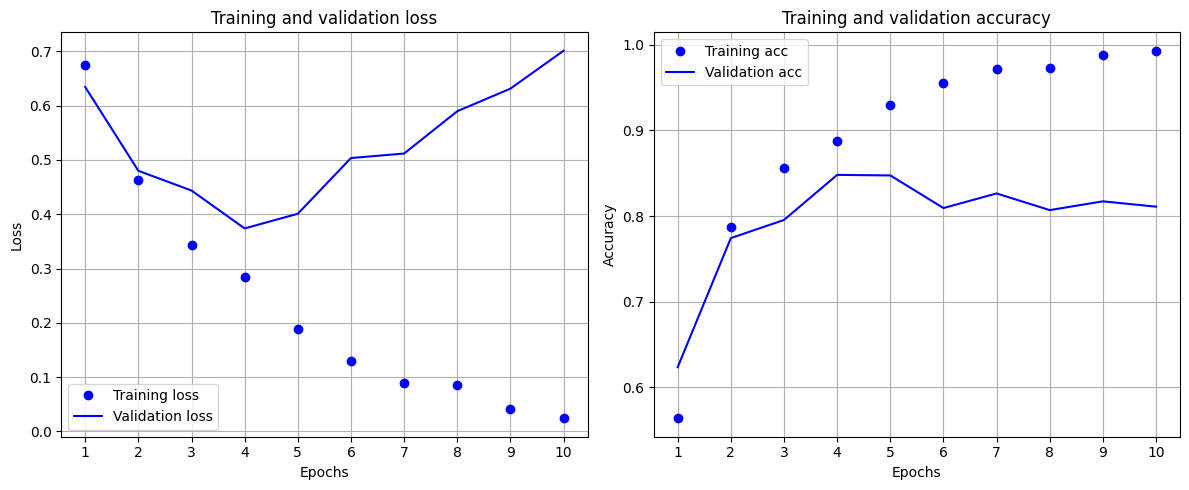

In [9]:
### Plotting results
plot_1model_train_val_charts(history_rnn, save_path='./imgs/rnn_model.png')

Lembremo-nos de a primeira abordagem ingênua a este conjunto de dados alcançou uma precisão de teste de 88%.

Infelizmente, esta pequena rede recorrente não se sai tão bem em comparação com essa referência (apenas 85% de precisão de validação). Parte do problema é que suas entradas consideram apenas as primeiras 500 palavras, em vez de sequências completas - portanto, a RNN tem acesso a menos informações do que o modelo de referência anterior. Outro problema é que a `SimpleRNN` não é eficaz ao processar sequências longas, como um texto.

Outros tipos de camadas recorrentes têm um desempenho muito melhor. Vamos dar uma olhada em algumas camadas mais avançadas.

**2. As camadas LSTM e GRU**

A `SimpleRNN` não é a única camada recorrente disponível no Keras. Existem outras duas: `LSTM` e `GRU`. Na prática, sempre se usará uma destas, porque a `SimpleRNN` é geralmente muito simplista para ser de real utilidade. A `SimpleRNN` tem um problema significativo: embora teoricamente deva ser capaz de reter, no tempo `t`, informações sobre entradas vistas muitos passos temporais antes, na prática, tais dependências de longo prazo são impossíveis de aprender. Isso se deve ao *vanishing gradient problem*, um efeito semelhante ao observado em redes não recorrentes (redes *feedforward*) que têm muitas camadas: à medida que você adiciona camadas a uma rede, ela eventualmente se torna difícil de treinar. As razões teóricas para esse efeito foram estudadas por Hochreiter, Schmidhuber e Bengio no início dos anos 1990. As camadas `LSTM` e `GRU` foram projetadas para resolver esse problema.

Vamos considerar a camada `LSTM`. O algoritmo subjacente Long Short-Term Memory (LSTM) foi desenvolvido por Hochreiter e Schmidhuber em 1997; foi a culminação de suas pesquisas sobre o *vanishing gradient problem*.

Esta camada é uma variante da camada `SimpleRNN`; ela adiciona uma maneira de transportar informações através de muitos passos temporais. Imagine uma esteira transportadora que funciona paralelamente à sequência que se está processando. Informações da sequência podem pular para a esteira em qualquer ponto, ser transportadas para um passo temporal posterior e pular, intactas, quando se precisar delas. Isso é essencialmente o que o LSTM faz: ele salva informações para uso posterior, evitando assim que sinais mais antigos desapareçam gradualmente durante o processamento.

**3. Um exemplo concreto de LSTM no Keras**

Agora, vamos considerar um exemplo concreto: vamos configurar um modelo usando uma camada LSTM e treiná-lo nos dados do IMDB. A rede é semelhante àquela com SimpleRNN que acabou de ser apresentada. Só especificamos a dimensionalidade de saída da camada LSTM; vamos deixar todos os outros argumentos (que são muitos) com os padrões do Keras. O Keras tem bons padrões, e as coisas quase sempre "funcionarão" sem que você precise gastar tempo ajustando os parâmetros manualmente.



Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - acc: 0.5950 - loss: 0.6552 - val_acc: 0.7958 - val_loss: 0.4362
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - acc: 0.8191 - loss: 0.4119 - val_acc: 0.7936 - val_loss: 0.4354
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - acc: 0.8614 - loss: 0.3373 - val_acc: 0.8610 - val_loss: 0.3298
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - acc: 0.8813 - loss: 0.3000 - val_acc: 0.8626 - val_loss: 0.3222
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - acc: 0.8981 - loss: 0.2673 - val_acc: 0.8778 - val_loss: 0.3053
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - acc: 0.9074 - loss: 0.2447 - val_acc: 0.7762 - val_loss: 0.6658
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - acc: 0.9105 - loss: 0.2381 - val_acc: 0.8766 - val_loss: 0.2959
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - acc: 0.9199 - loss: 0.2158 - val_acc: 0.8750 - val_loss: 0.3662
Epoch 9/10
196/196 ━━━━━━━━━━━━━

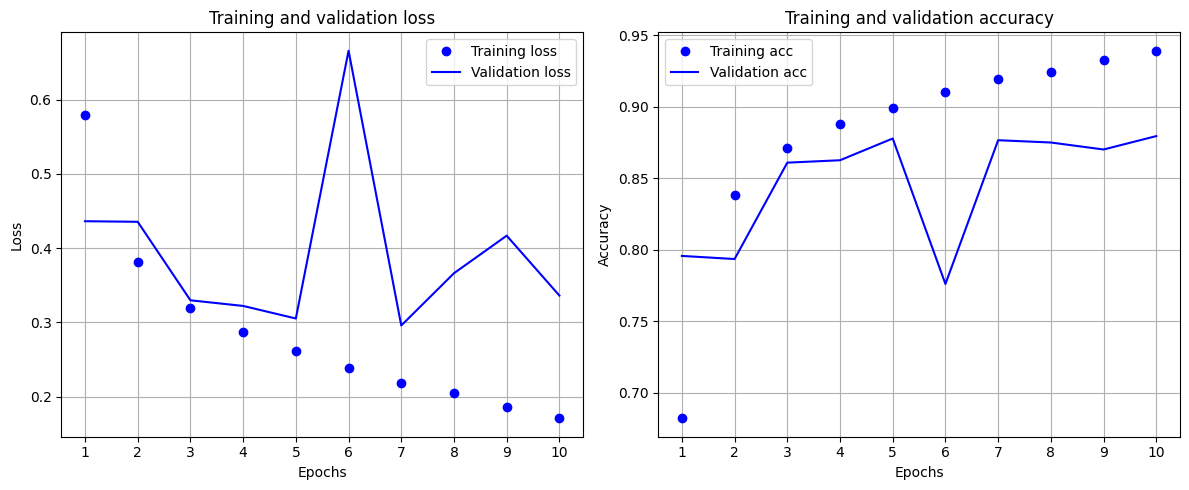

In [10]:
###  Using the LSTM layer in Keras

from keras.layers import LSTM
from keras import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

set_random_seed(0)

model_lstm = Sequential()
model_lstm.add(Embedding(max_features, 32))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='rmsprop',
  loss='binary_crossentropy',
  metrics=['acc'])
history_lstm = model_lstm.fit(input_train, y_train,
                              epochs=10,
                              batch_size=128,
                              validation_data=(input_valid, y_valid))

### Plotting results

plot_1model_train_val_charts(history_lstm)

**Exercício**

Faça uma discussão dos resultados. Compare-os com os outros modelos que usamos anteriormente para a mesma base de dados. Deveríamos esperar resultados melhores?

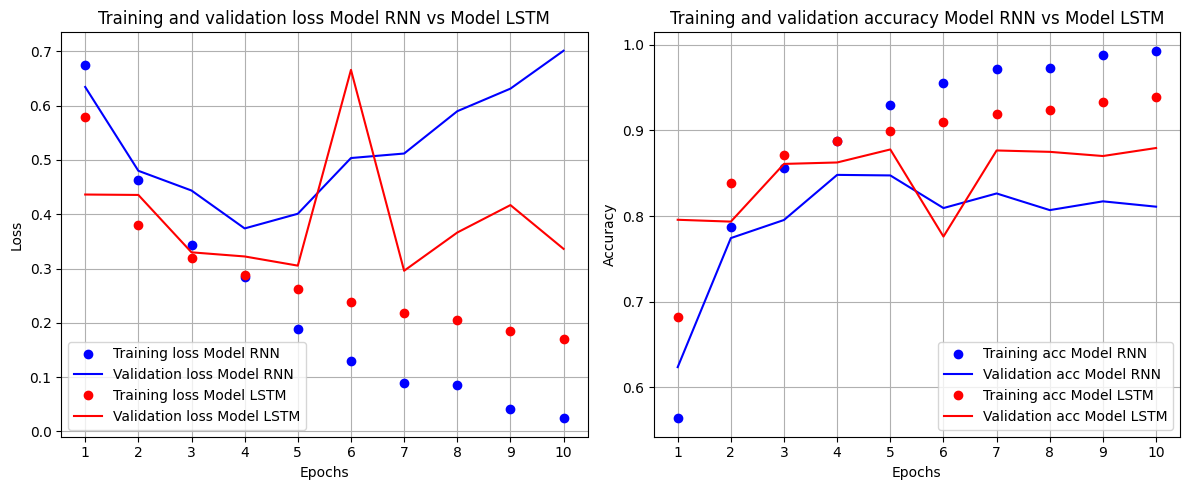

In [11]:
# Comparing the lstm and rnn models
plot_train_val_charts(history_rnn, history_lstm, 'RNN', 'LSTM', save_path='./imgs/rnn_lstm.png')

Camadas densas se beneficiam de dados em um formato diferente dos RNNs. Vamos remodelar os dados em um formato vetorizado e ajustar novamente o modelo.

In [12]:
# Creating a dropout-regularized Dense Model
set_random_seed(0)
model_dense_reg_sequence = models.Sequential()
model_dense_reg_sequence.add(layers.Input(shape=(maxlen,)))
model_dense_reg_sequence.add(layers.Dense(16, activation='relu'))
model_dense_reg_sequence.add(layers.Dropout(0.2))
model_dense_reg_sequence.add(layers.Dense(16, activation='relu'))
model_dense_reg_sequence.add(layers.Dropout(0.2))
model_dense_reg_sequence.add(layers.Dense(1, activation='sigmoid'))

model_dense_reg_sequence.compile(optimizer='rmsprop',
                         loss='binary_crossentropy',
                         metrics=['acc'])

# Training the model
history_dense_reg_sequence = model_dense_reg_sequence.fit(input_train, y_train,
                                          epochs=10,
                                          batch_size=128,
                                          validation_data=(input_valid, y_valid))

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5022 - loss: 114.7580 - val_acc: 0.4994 - val_loss: 0.9663
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.4991 - loss: 1.0019 - val_acc: 0.4990 - val_loss: 0.7198
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.4986 - loss: 0.7236 - val_acc: 0.4985 - val_loss: 0.7040
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5006 - loss: 0.7093 - val_acc: 0.4985 - val_loss: 0.6976
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.4995 - loss: 0.6973 - val_acc: 0.4988 - val_loss: 0.6967
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.4976 - loss: 0.6982 - val_acc: 0.4984 - val_loss: 0.6990
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.4986 - loss: 0.6973 - val_acc: 0.4981 - val_loss: 0.6975
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.4987 - loss: 0.6949 - val_acc: 0.4982 - val_loss: 0.6982
Epoch 9/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

In [13]:
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results
# x_train = vectorize_sequences(input_train)
# x_test = vectorize_sequences(input_test)

# print(x_train[0])

# y_train = np.asarray(train_labels).astype('float32')
# y_test = np.asarray(test_labels).astype('float32')

In [14]:
vector_size = 10000
x_train_vec = vectorize_sequences(x_train, dimension=vector_size)
x_test_vec = vectorize_sequences(x_test, dimension=vector_size)
x_valid_vec = vectorize_sequences(x_valid, dimension=vector_size)

In [15]:
# Creating a dropout-regularized Dense Model
set_random_seed(0)
model_dense_reg_vector = models.Sequential()
model_dense_reg_vector.add(layers.Input(shape=(vector_size,)))
model_dense_reg_vector.add(layers.Dense(16, activation='relu'))
model_dense_reg_vector.add(layers.Dropout(0.2))
model_dense_reg_vector.add(layers.Dense(16, activation='relu'))
model_dense_reg_vector.add(layers.Dropout(0.2))
model_dense_reg_vector.add(layers.Dense(1, activation='sigmoid'))

model_dense_reg_vector.compile(optimizer='rmsprop',
                         loss='binary_crossentropy',
                         metrics=['acc'])

# Training the model
history_dense_reg_vector = model_dense_reg_vector.fit(x_train_vec, y_train,
                                          epochs=10,
                                          batch_size=128,
                                          validation_data=(x_valid_vec, y_valid))

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.7383 - loss: 0.5340 - val_acc: 0.8860 - val_loss: 0.2901
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8996 - loss: 0.2718 - val_acc: 0.8872 - val_loss: 0.2827
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9243 - loss: 0.2096 - val_acc: 0.8817 - val_loss: 0.3186
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9403 - loss: 0.1758 - val_acc: 0.8824 - val_loss: 0.3352
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9511 - loss: 0.1424 - val_acc: 0.8783 - val_loss: 0.3787
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9578 - loss: 0.1269 - val_acc: 0.8762 - val_loss: 0.4327
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9649 - loss: 0.1168 - val_acc: 0.8728 - val_loss: 0.4688
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9680 - loss: 0.0991 - val_acc: 0.8701 - val_loss: 0.5044
Epoch 9/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

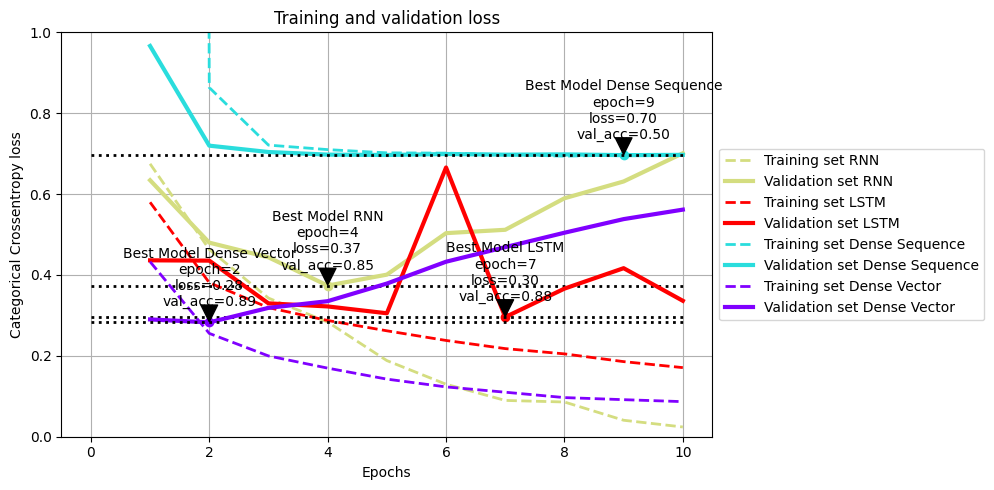

In [23]:
plot_train_val_loss(history_rnn, history_lstm, history_dense_reg_sequence, history_dense_reg_vector, history_labels=['RNN', 'LSTM', 'Dense Sequence', 'Dense Vector'],
                    ylim=(0, 1), save_path='./imgs/rnn_lstm_dense_comparasion.png')

In [24]:
# Map models to their respective test accuracies
models_test_acc = {
    'RNN': model_rnn.evaluate(input_test, y_test)[1],
    'LSTM': model_lstm.evaluate(input_test, y_test)[1],
    'Dense Sequence': model_dense_reg_sequence.evaluate(input_test, y_test)[1],
    'Dense Vector': model_dense_reg_vector.evaluate(x_test_vec, y_test)[1]
    }
models_test_acc

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.8134 - loss: 0.7143
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - acc: 0.8849 - loss: 0.3365
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - acc: 0.5009 - loss: 0.6968
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - acc: 0.8742 - loss: 0.5864


{'RNN': 0.813040018081665,
 'LSTM': 0.8824800252914429,
 'Dense Sequence': 0.5016000270843506,
 'Dense Vector': 0.8708000183105469}

## Análise

O melhor modelo foi o LSTM, com 88% de acurácia no conjunto de dados de teste. O modelo Dense Vectorized apresentou uma acurácia surpreendente de 87%, enquanto o modelo RNN com Embedding apresentou uma acurácia de 81%. Portanto, o modelo LSTM superou os outros modelos, mas o modelo Dense Vectorized também apresentou um bom desempenho e teve um tempo de treinamento significativamente menor. O modelo Dense Sequence foi o que apresentou o pior desempenho, com uma acurácia de 50%, o que faz sentido, pois a camada Dense não é a mais adequada para lidar com dados sequenciais. Os modelos LSTM e Dense Vectorized parecem ainda terem potencial para melhorar, pois sua curva de perda ainda não atingiu a estabilidade.

### Estatísticas dos modelos
| Modelo | Acurácia(teste) | Tempo de treinamento |
|--------|-----------------|----------------------|
| LSTM | 88.2% | 3min 26s |
| Dense Vectorized | 87.0% | 6s |
| RNN com Embedding | 81.3% | 1min 39s |
| Dense Sequence | 50.1% | 3s |